# DATASETS & DATALOADERS

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the `Dataset` to enable easy access to the samples.

PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that subclass torch.utils.data.Dataset and implement functions specific to the particular data. They can be used to prototype and benchmark your model. You can find them here: Image Datasets, Text Datasets, and Audio Datasets

## Loading a Dataset

Here is an example of how to load the $\text{\red{Fashion-MNIST}}$ dataset from TorchVision. Fashion-MNIST is a dataset of Zalando’s article images consisting of 60,000 training examples and 10,000 test examples. Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.

We load the FashionMNIST Dataset with the following parameters:
- root is the path where the train/test data is stored,
- train specifies training or test dataset,
- download=True downloads the data from the internet if it’s not available at root.
- transform and target_transform specify the feature and label transformations

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

c:\Users\Admin\miniconda3\envs\aiml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    transform=ToTensor()
)

## Iterating and Visualizing the Dataset
We can index `Datasets` manually like a list: `training_data[index]`. We use `matplotlib` to visualize some samples in our training data.

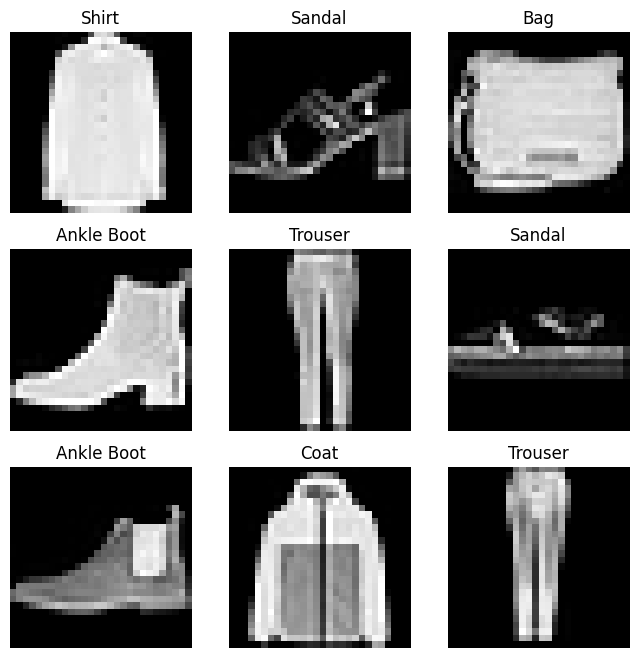

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Creating a Custom Dataset for your files

A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`. Take a look at this implementation; the FashionMNIST images are stored in a directory `img_dir`, and their labels are stored separately in a CSV file `annotations_file`.

In the next sections, we’ll break down what’s happening in each of these functions.

In [5]:
import os
import pandas as pd
from torchvision.io import read_image

In [6]:

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### `__init__`
The `__init__` function is run once when instantiating the Dataset object. We initialize the directory containing the images, the annotations file, and both transforms (covered in more detail in the next section).

The labels.csv file looks like:

```csv 
    tshirt1.jpg, 0
    tshirt2.jpg, 0
    ......
    ankleboot999.jpg, 9
```

In [7]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

### `__len__`
The `__len__` function returns the number of samples in our dataset.

In [8]:
def __len__(self):
    return len(self.img_labels)

### `__getitem__`
The `__getitem__` function loads and returns a sample from the dataset at the given index `idx`. Based on the index, it identifies the image’s location on disk, converts that to a tensor using `read_image`, retrieves the corresponding label from the csv data in `self.img_labels`, calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a tuple.

In [9]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

## Preparing your data for training with DataLoaders
The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s `multiprocessing` to speed up data retrieval.

`DataLoader` is an iterable that abstracts this complexity for us in an easy API.

In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Iterate through the DataLoader
We have loaded that dataset into the `DataLoader` and can iterate through the dataset as needed. Each iteration below returns a batch of `train_features` and `train_labels` (containing `batch_size=64` features and labels respectively). Because we specified `shuffle=True`, after we iterate over all batches the data is shuffled (for finer-grained control over the data loading order, take a look at `Samplers`).

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


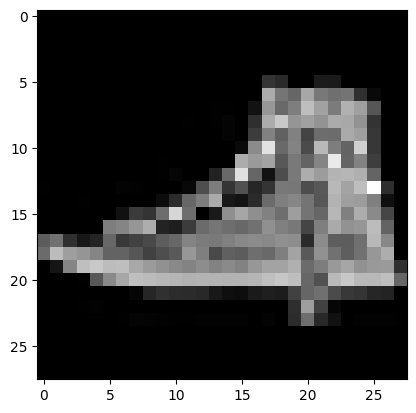

Label: 5


In [11]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")